prepareing data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os


  
data = pd.read_csv('anemia_data_set.csv')


# Display first rows
print("Data preview:")
print(data.head())

Data preview:
   HMB  fibroid_size  uf_location         MD  anemia_risk
0    1     12.511052            1   4.817583    60.000000
1    1      3.879385            1  11.302656    89.166667
2    1     10.066359            0  14.412047    79.294431
3    1      8.258693            2   5.809143    60.000000
4    1     10.219096            2   4.547906    65.989330


Normalizing data 

In [3]:
# Step 2: Prepare features and target
X = data[['HMB', 'fibroid_size', 'uf_location', 'MD']].values  # Features
y = data['anemia_risk'].values  # Target

In [4]:
# Normalize features and target separately
X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)  # Features

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Target


In [5]:
# Step 3: Split data into training and testing sets
# Training data 60%
# Testing data 40%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [6]:
# Reshape input for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Input shape for CNN: {X_train.shape}")

Training samples: 1539
Testing samples: 1027
Input shape for CNN: (1539, 4, 1)


In [7]:
# Build deep learning model 

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=2, activation='relu'),
    Dropout(0.3),
    Conv1D(32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])


# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             192       
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [8]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
# Training model
# 25 epochs of training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/25
77/77 [==============================] - 3s 13ms/step - loss: 0.0928 - mae: 0.2273 - val_loss: 0.0212 - val_mae: 0.1264
Epoch 2/25
77/77 [==============================] - 1s 7ms/step - loss: 0.0285 - mae: 0.1380 - val_loss: 0.0181 - val_mae: 0.1081
Epoch 3/25
77/77 [==============================] - 1s 7ms/step - loss: 0.0219 - mae: 0.1194 - val_loss: 0.0147 - val_mae: 0.0944
Epoch 4/25
77/77 [==============================] - 1s 7ms/step - loss: 0.0210 - mae: 0.1176 - val_loss: 0.0117 - val_mae: 0.0841
Epoch 5/25
77/77 [==============================] - 0s 6ms/step - loss: 0.0182 - mae: 0.1077 - val_loss: 0.0087 - val_mae: 0.0713
Epoch 6/25
77/77 [==============================] - 0s 6ms/step - loss: 0.0170 - mae: 0.1050 - val_loss: 0.0096 - val_mae: 0.0735
Epoch 7/25
77/77 [==============================] - 0s 6ms/step - loss: 0.0154 - mae: 0.0983 - val_loss: 0.0082 - val_mae: 0.0693
Epoch 8/25
77/77 [==============================] - 0s 6ms/step - loss: 0.0139 - mae: 0.0

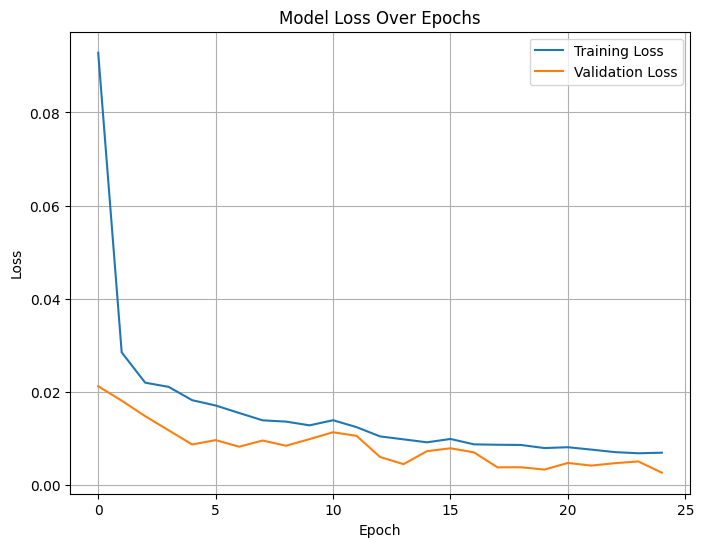

In [9]:
# training and validation loss

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [10]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

33/33 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0337
Test Loss: 0.0022, Test MAE: 0.0337


33/33 [==============================] - 0s 2ms/step


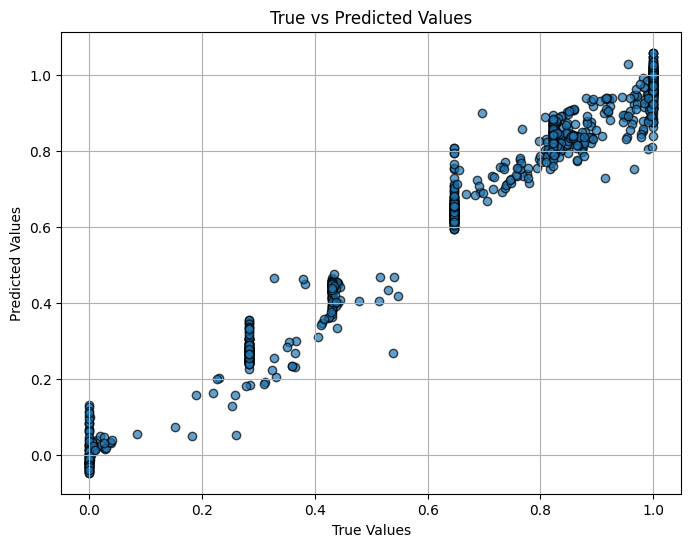

In [11]:
# Predict and visualize results
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.grid()
plt.show()

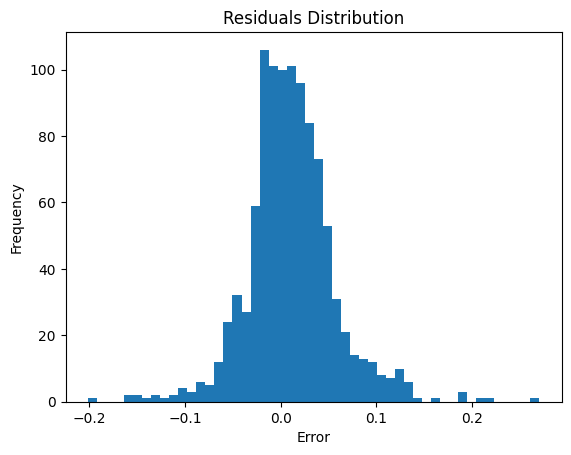

In [12]:
residuals = y_test - y_pred.flatten()
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


In [14]:
# العينة الجديدة
sample_data = np.array([[1, 12.5, 1, 4.8]])  # قيم العينة الجديدة

# تطبيع العينة باستخدام X_scaler
sample_data_normalized = X_scaler.transform(sample_data)

# إعادة تشكيل العينة لتتناسب مع شكل الإدخال المطلوب للنموذج
sample_data_reshaped = sample_data_normalized.reshape(1, -1, 1)

# التنبؤ باستخدام النموذج
predicted_risk_normalized = model.predict(sample_data_reshaped)

# إعادة تحويل القيمة المتوقعة إلى النطاق الأصلي
predicted_risk = y_scaler.inverse_transform(predicted_risk_normalized)

# طباعة النتيجة
print("Sample Input (Normalized):", sample_data_normalized.flatten())
print(f"Predicted Anemia Risk (Original Scale): {predicted_risk[0][0]:.4f}")


1/1 [==============================] - 0s 138ms/step
Sample Input (Normalized): [1.         0.78182278 0.5        0.21535852]
Predicted Anemia Risk (Original Scale): 59.4588
